# Multi Armed Bandit

In [27]:
# Print versions 
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(scipy.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.1
numpy: 1.15.4
scipy: 1.1.0
matplotlib: 3.1.1
seaborn: 0.9.0


# Imports / Functions / Set up

In [31]:
#%matplotlib notebook

import sys
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(5)
#

In [55]:
def pull(i):
    """
    Pull the arm of the bandit with index 'i' and return 1 if win, else 0 
    """
    
    if np.random.rand() < p_bandits[i]:
        return 1
    else:
        return 0

In [56]:
def plot_priors(priors, step, ax):
    """
    Plot the priors for the current step
    """
    plot_x = np.linspace(.001, .999, 100)
    
    for prior in priors:
        y = prior.pdf(plot_x)
        p = ax.plot(plot_x, y)
        
        ax.fil_between(plot_x, y, 0, alpha= .2)
    ax.set_xlim([0,1])
    ax.set_ylim(bottom=0)
    ax.set_title('Priors at step {step:d}')

In [54]:
#Number of Bandits to be Simulated

nb_bandits = 4

# Probability per Bandit
p_bandits = [.2, .35, .5, .57]

In [57]:
# Plots
plots = [1, 2, 5, 10, 25, 50, 100, 200, 500, 1000]

# Explanation

### Bayesian Iterpretation

Each pull of a bandit will result in a win (1) or loss (0) depending on the assigned probability. The higher the probability the more likley a win will be returned. We currently don't know the probabilty so we will model it based on our oberservations of a certain bandit resulting in a win or not. We will model the unknown probability with a parameter θ. Based on observing a single outcome x we can model the distrubution as P(θ | x). Using [Bayes Rule](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can write it as:

P(θ | x) = (P(x |θ)P(θ)) / P(x)

P(θ |x) is the posterior probability of θ after observing x. We will be able to compute this with the likelihood P(x|θ) and prior P(θ). In the case of P(x|θ) it will follow a [bernouilli distrubution](https://en.wikipedia.org/wiki/Beta_distribution).



### Beta Prior

For P(θ) I have chosen to follow a beta distrubution due to it being the [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions) of the bernouilli distrubution. This means that the likelihood function P(x|θ) will follow a bernoulli distrubution and the prior P(θ) is Beta distrubuted therefore the Posterior P(θ|x) will also followd a beta distrubution.

In more detail if the prior is Beta(α,β), then a win will result in Beta(α+1,β) and a loss Beta(α,β+1)


This means that after every observation we can use the posterior as the prior for the next bandit pull

### Maximising Reward // Minimising Regret

The goal of the multi armed bandit is to maximise reward, i.e find the best performing method. There is an exploitation - exploration tradeoff we have to make here. The more times the best percieved bandit is used the more certain we become of its probability. But other bandits we haven't pulled as often may have lower than expected probabilities but there is higher uncertainty. There is a potential chance that a different bandit has a better probability.

I will use the [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) to overcome this problem. Thompson sampling works by sampling the probability θ from each the prior and retrieve the bandit with the highest sampled probability. 

We will start with the prior Beta(α=1,β=1), which is a [uniform](https://en.wikipedia.org/wiki/Uniform_distribution_%28continuous%29) prior between 0 and 1. The run is simulated for 1000 steps and the results plotted below.

# Plotting

<IPython.core.display.Javascript object>


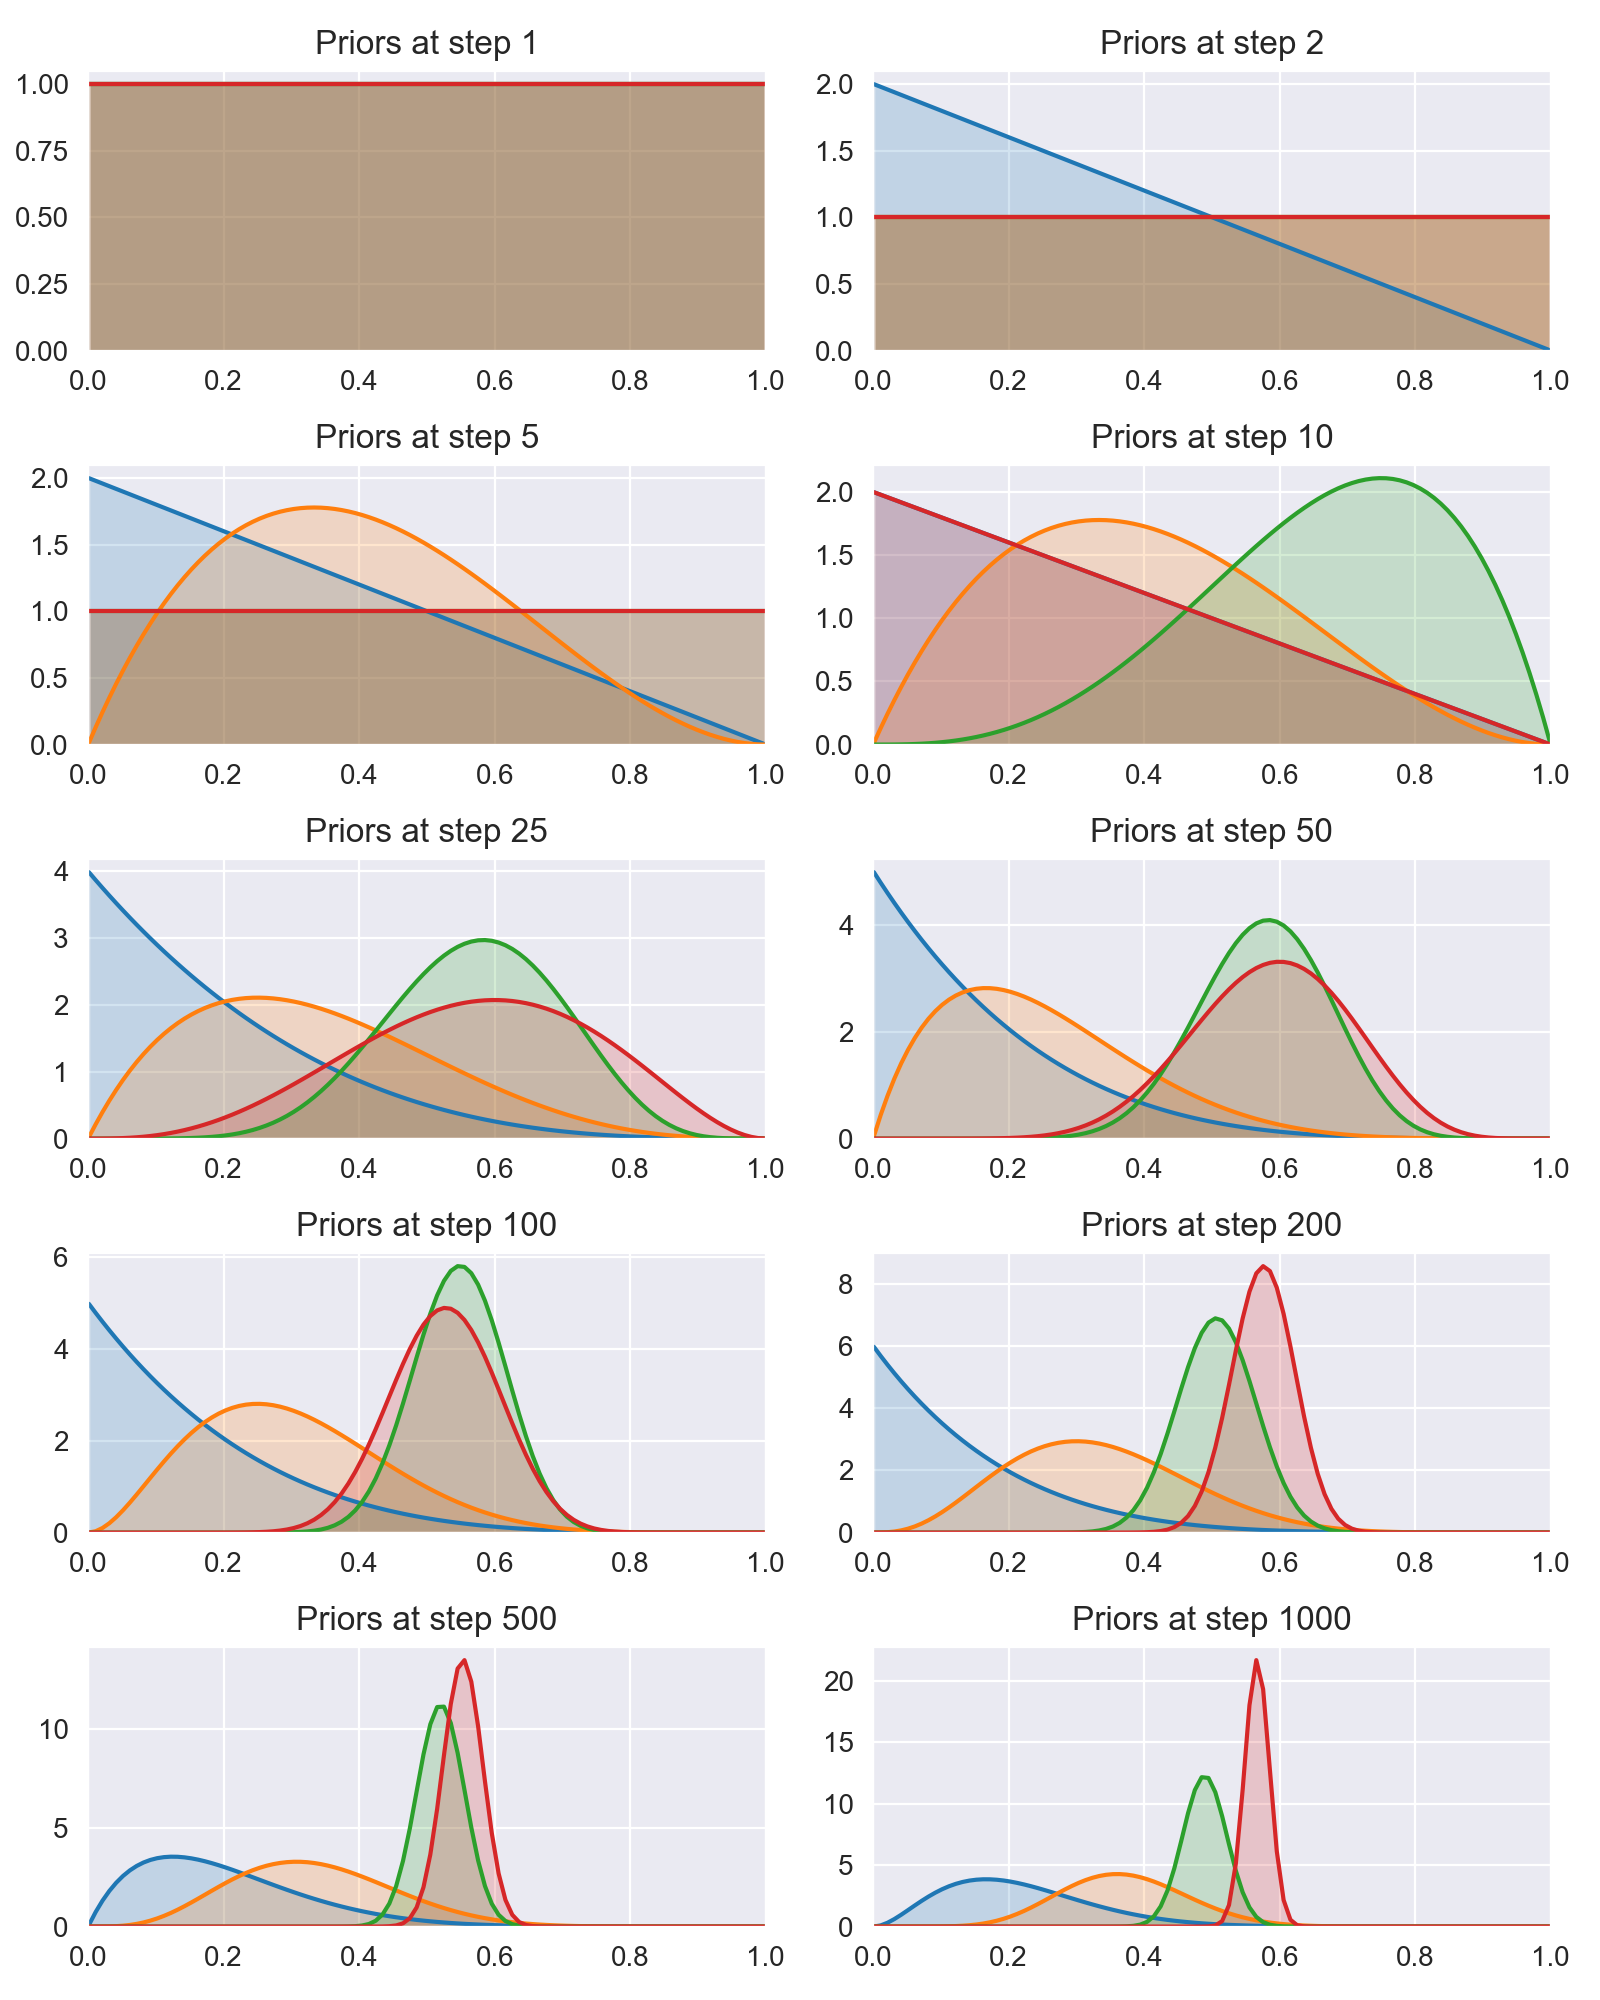

In [58]:
# Simulated Multi - Armed Bandit process and update posteriors

# Set up plots

fig, ax = plt.subplots(5, 2, figsize=(8,10))

ax = ax.flat

# The number of trials and wins will represent the prior for each 
# bandit with the help of the Beta Distrubutions

trials = [0, 0, 0, 0 ]
wins = [0, 0, 0, 0]

n = 1000

for step in range(1, n+1):
    # Define the prior based on current observations
    bandits_prior = [stats.beta(a = 1+w, b = 1+t-w) for t, w in zip(trials, wins)]
    
    if step in plots:
        plot(bandits_prior, step, next(ax))
        
    # Sample a probability theta for each bandit
    theta_sample = [d.rvs(1) for d in bandits_prior]
    
    # choose a bandit probability 
    chosen_bandit = np.argmax(theta_sample)
    
    # pull the bandit
    x = pull(chosen_bandit)
    
    trials[chosen_bandit] += 1
    wins[chosen_bandit] += x
    
plt.tight_layout()
plt.show()

In [52]:
empirical_p_bandits = [(1+w)/(1+t) for t,w in zip(trials, wins)]

for i in range(nb_bandits):
    print((f'True prob={p_bandits[i]:.2f};  '
           f'Empirical prob={empirical_p_bandits[i]:.2f};  '
           f'Trials ={trials[i]:.2f};  '
          ))

True prob=0.20;  Empirical prob=0.12;  Trials =7.00;  
True prob=0.25;  Empirical prob=0.32;  Trials =30.00;  
True prob=0.50;  Empirical prob=0.54;  Trials =261.00;  
True prob=0.60;  Empirical prob=0.57;  Trials =702.00;  
